In [1]:
import numpy as np

import pandas as pd

import xarray as xr

import glob

import matplotlib as mpl

import matplotlib.pyplot as plt

import math as mt

from math import e

import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from random import seed
from random import randint

from scipy.signal import hilbert
import statistics
from scipy.stats import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pickle
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

 # Read Fog file

In [2]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])

#fogData.fogdata

#fogData.fogdata.sum(dim=['stations','months','days']).plot()
#fogData.fogdata.sum(dim=['stations','months','days'])

In [3]:
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
# fogData.fogdata.values.shape
# fogData.stations
#plt.figure(figsize=[16,8])
#fg.fogdata.resample(time="1y").sum().sum(dim='stations').plot()
#fg.fogdata.time    

# Read ERA5 Data

In [4]:
t2mData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_t2m_3hourly_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_u10_3hourly_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_v10_3hourly_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_d2m_3hourly_NovDecJan.nc')
t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
u10D = u10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
v10D = v10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
d2mD = d2mData.sel(latitude=slice(32,24),longitude=slice(74,86))

In [5]:
# Calculate wind speed and relative humidity

ws = ((v10D.v10[:,0,:,:].values**2)+(u10D.u10[:,0,:,:].values**2))**0.5

ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

rh = (e**((17.625*(d2mD.d2m[:,0,:,:].values-273.15))/(243.04+(d2mD.d2m[:,0,:,:].values-273.15)))/e**((17.625*(t2mD.t2m[:,0,:,:].values-273.15))/(243.04+(t2mD.t2m[:,0,:,:].values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

#rh_ds

             

In [6]:
# Read 850 data

tz850Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_850_tqz_3hourly_NovDecJan.nc')

uv850Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_850_uv_3hourly_NovDecJan.nc')

tz850D = tz850Data.sel(latitude=slice(32,24),longitude=slice(74,86))

uv850D = uv850Data.sel(latitude=slice(32,24),longitude=slice(74,86))

In [7]:
#Calculate inv

inv=t2mD.t2m[:,0,:,:].values-tz850D.t[:,0,:,:].values

inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

inv_ds.attrs

inv_ds.attrs['units']='K'

inv_ds.attrs['long_name']='t2m - t850'

#inv_ds.inv

In [8]:
#u shear calculation

ushear=(uv850D.u[:,0,:,:].values-u10D.u10[:,0,:,:].values)/(tz850D.z[:,0,:,:].values/9.81) 

ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

ushear_ds.attrs['units']='s-1'

ushear_ds.attrs['long_name']='(u10 - u850)/z850'


#ushear_ds.ushear

#inv

In [9]:
# Read W700

w700Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_700_w_3hourly_NovDecJan.nc')

w700D = w700Data.sel(latitude=slice(32,24),longitude=slice(74,86))

# Read Orography

OroData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/ERA5IGP_Orography.nc')

OroData.data_vars

OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))

oro = OroD.z

oro.values = OroD.z.values/9.81

oro.attrs

oro.attrs['units']='meter'

oro.attrs['long_name']='Orography'

l = np.arange(0,1000,100)

#oro[0,:,:].plot(levels=l,extend='both',cmap='jet')

In [10]:
# Create Mask altitude >500 m NaN

oro.values[oro.values>500.1]=np.NaN

mask=oro.values/oro.values

# chk mask

t2mD.t2m.values=t2mD.t2m.values*mask

#t2mData.t2m[0,0,:,:].plot(cmap='jet')

#plt.figure(figsize=[20,10])

#t2mData.mean(dim=['latitude','longitude']).t2m[:,0].plot()

t2mTS=t2mD.mean(dim=['latitude','longitude'], skipna=True).t2m[:,0]

In [11]:
ws_ds.ws.values=ws_ds.ws.values*mask
wsTS=ws_ds.mean(dim=['latitude','longitude'], skipna=True).ws
#wsTS.plot()


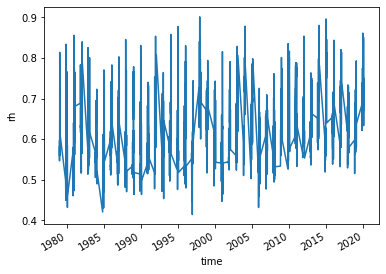

In [12]:
rh_ds.rh.values=rh_ds.rh.values*mask
#rh_ds.rh[:].mean(dim=['latitude','longitude'], skipna=True).plot()
rhTS=rh_ds.mean(dim=['latitude','longitude'], skipna=True).rh
rhTS.plot()

In [13]:
w700D.w.values=w700D.w.values*mask
w700D.mean(dim=['latitude','longitude'])
wTS=w700D.mean(dim=['latitude','longitude'], skipna=True).w[:,0]
#wTS.plot()

In [14]:
inv_ds.inv.values=inv_ds.inv.values*mask
invTS=inv_ds.mean(dim=['latitude','longitude'], skipna=True).inv
#invTS.plot()

In [15]:
ushear_ds.ushear.values=ushear_ds.ushear.values*mask
ushearTS=ushear_ds.mean(dim=['latitude','longitude'], skipna=True).ushear
#ushearTS.plot()

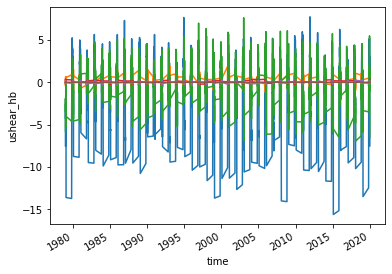

In [16]:
t2m_hb = np.imag(hilbert(t2mTS.values[(t2mTS.time.dt.year<2020)],axis=0))
t2m_hb_ds = xr.Dataset({'t2m_hb': (('time'), t2m_hb)}, coords={'time': t2mTS[(t2mTS.time.dt.year<2020)].time})
t2m_hb_ds.t2m_hb.plot()

ws_hb = np.imag(hilbert(wsTS.values[(wsTS.time.dt.year<2020)],axis=0))
ws_hb_ds = xr.Dataset({'ws_hb': (('time'), ws_hb)}, coords={'time': wsTS[(wsTS.time.dt.year<2020)].time})
ws_hb_ds.ws_hb.plot()

inv_hb = np.imag(hilbert(invTS.values[(invTS.time.dt.year<2020)],axis=0))
inv_hb_ds = xr.Dataset({'inv_hb': (('time'), inv_hb)}, coords={'time': invTS[(invTS.time.dt.year<2020)].time})
inv_hb_ds.inv_hb.plot()

rh_hb = np.imag(hilbert(rhTS.values[(rhTS.time.dt.year<2020)],axis=0))
rh_hb_ds = xr.Dataset({'rh_hb': (('time'), rh_hb)}, coords={'time': rhTS[(rhTS.time.dt.year<2020)].time})
rh_hb_ds.rh_hb.plot()

w_hb = np.imag(hilbert(wTS.values[(wTS.time.dt.year<2020)],axis=0))
w_hb_ds = xr.Dataset({'w_hb': (('time'), w_hb)}, coords={'time': wTS[(wTS.time.dt.year<2020)].time})
w_hb_ds.w_hb.plot()

ushear_hb = np.imag(hilbert(ushearTS.values[(ushearTS.time.dt.year<2020)],axis=0))
ushear_hb_ds = xr.Dataset({'ushear_hb': (('time'), ushear_hb)}, coords={'time': ushearTS[(ushearTS.time.dt.year<2020)].time})
ushear_hb_ds.ushear_hb.plot()

In [17]:
#Create area averaged values and get same days as fog days i.e. Dec Jan

# a,b = xr.align(fg.fogdata.sum(dim='stations'),t2mTS)

t2m=t2mTS[((t2mTS.time.dt.month>11) | (t2mTS.time.dt.month<2)) & (t2mTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2005-12-31'))

ws=wsTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2005-12-31'))

inv=invTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2005-12-31'))

rh=rhTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2005-12-31'))

w=wTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2005-12-31'))

ushear=ushearTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2005-12-31'))

#t2m

In [273]:
t2mhb=t2m_hb_ds.t2m_hb[((t2m_hb_ds.time.dt.month>11) | (t2m_hb_ds.time.dt.month<2)) & (t2m_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
invhb=inv_hb_ds.inv_hb[((inv_hb_ds.time.dt.month>11) | (inv_hb_ds.time.dt.month<2)) & (inv_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
wshb=ws_hb_ds.ws_hb[((ws_hb_ds.time.dt.month>11) | (ws_hb_ds.time.dt.month<2)) & (ws_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
rhhb=rh_hb_ds.rh_hb[((rh_hb_ds.time.dt.month>11) | (rh_hb_ds.time.dt.month<2)) & (rh_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
whb=w_hb_ds.w_hb[((w_hb_ds.time.dt.month>11) | (w_hb_ds.time.dt.month<2)) & (w_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
ushearhb=ushear_hb_ds.ushear_hb[((ushear_hb_ds.time.dt.month>11) | (ushear_hb_ds.time.dt.month<2)) & (ushear_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

In [18]:
#X       = pd.DataFrame([t2m.values,ws.values,rh.values,inv.values,w.values,ushear.values*100.0,
#                        t2mhb.values,wshb.values,rhhb.values,invhb.values,whb.values,ushearhb.values]).T[:]

X       = pd.DataFrame([t2m.values,ws.values,rh.values,inv.values,w.values,ushear.values*100.0]).T[:]


X.index = pd.to_datetime(t2m.time.values)
X

,0,1,2,3,4,5
1980-01-01 10:30:00,288.873718,2.103235,0.752254,5.917946,-0.153306,0.267513
1980-01-02 10:30:00,288.148560,1.536837,0.766426,6.877218,-0.033940,0.140727
1980-01-03 10:30:00,286.932129,1.963692,0.752228,6.723764,0.075506,0.069107
1980-01-04 10:30:00,285.958344,1.931438,0.724486,5.591223,0.035796,0.041987
1980-01-05 10:30:00,286.157257,1.960673,0.686824,4.766602,0.048788,0.153410
...,...,...,...,...,...,...
2005-12-27 10:30:00,288.561432,0.980443,0.571331,2.212489,-0.020064,0.183717
2005-12-28 10:30:00,288.814148,0.897640,0.601186,3.184523,0.047422,0.203184
2005-12-29 10:30:00,288.646515,1.170663,0.620830,3.673306,0.032910,0.152118
2005-12-30 10:30:00,288.782410,1.624242,0.646703,4.227672,-0.006027,0.175539


In [19]:
norm = StandardScaler().fit(X)
    # transform training data
X = norm.transform(X)
X

array([[ 0.14766572,  0.75136874,  1.36443881,  1.04651019, -2.58104015,
         0.89527525],
       [-0.2410063 , -0.48203214,  1.53568843,  1.55773016, -0.97395294,
        -0.22926405],
       [-0.89299128,  0.44749689,  1.36412551,  1.47595082,  0.49957732,
        -0.864501  ],
       ...,
       [ 0.0258888 , -1.27942113, -0.22363043, -0.14971378, -0.07391528,
        -0.12823038],
       [ 0.09872596, -0.29169762,  0.08900412,  0.1457215 , -0.59814619,
         0.07950267],
       [ 0.4311467 ,  0.19628033,  0.02613884,  0.09049524,  0.29414831,
         0.07371272]])

In [20]:
y=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2005-12-31'))
y=y/25.0
y

<xarray.DataArray 'fogdata' (time: 1612)>
array([0.32, 0.4 , 0.4 , ..., 0.56, 0.6 , 0.52])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2005-12-31

In [21]:
seed(0)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
reg= GradientBoostingRegressor(n_estimators=300, min_samples_leaf=20, max_depth= 3,learning_rate=0.04,random_state=0).fit(X_train, y_train)
regLin=LinearRegression().fit(X_train, y_train)
f_imp=reg.feature_importances_

print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))


print(regLin.score(X_train, y_train))
print(regLin.score(X_test, y_test))

0.7136991488887043
0.5494430369658483
0.47038746846464496
0.47894890833519943


<ipython-input-22-a599dfafecb1>:3: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie(f_imp, labels=labels,colors=colors, autopct='%1.1f%%', pctdistance=0.8, labeldistance=1.0)


[[1.         0.82557625]
 [0.82557625 1.        ]]
[[1.         0.84793809]
 [0.84793809 1.        ]]
[[1.        0.7414217]
 [0.7414217 1.       ]]


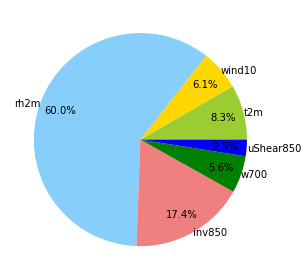

In [22]:

labels = ["t2m","wind10","rh2m","inv850","w700","uShear850"]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','green','blue','grey','red','brown','skyblue','yellow','pink']
plt.pie(f_imp, labels=labels,colors=colors, autopct='%1.1f%%', pctdistance=0.8, labeldistance=1.0)
plt.tight_layout()
#plt.savefig('GradBoostAllDays.png')

y_pred=reg.predict(X)
y_pred_test=reg.predict(X_test)
y_pred_train=reg.predict(X_train)
y_predLin=regLin.predict(X)
print(np.corrcoef(y,y_pred))
print(np.corrcoef(y_train,y_pred_train))
print(np.corrcoef(y_test,y_pred_test))



# plot y obs and y_pred monthly

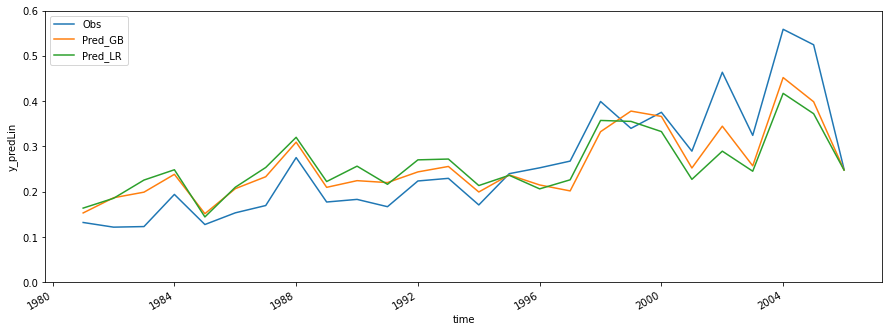

In [23]:
y_ds=xr.Dataset({'y': (('time'), y)}, coords={'time': t2m.time})
y_pred_ds=xr.Dataset({'y_pred': (('time'), y_pred)}, coords={'time': y.time})
y_predLin_ds=xr.Dataset({'y_predLin': (('time'), y_predLin)}, coords={'time': y.time})
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.plot(label='Pred_GB')
y_predLin_ds.resample(time='1Y').mean().y_predLin.plot(label='Pred_LR')
plt.ylim(0, 0.6)
plt.legend()

plt.savefig('../obs_yearly.jpeg',dpi=300)

In [24]:
print(np.corrcoef(y_ds.resample(time='1Y').mean().y,y_pred_ds.resample(time='1Y').mean().y_pred))
print(np.corrcoef(y_ds.resample(time='1Y').mean().y,y_predLin_ds.resample(time='1Y').mean().y_predLin))
#print(np.corrcoef(y,y_predLin))

[[1.         0.92237037]
 [0.92237037 1.        ]]
[[1.         0.85192701]
 [0.85192701 1.        ]]


In [25]:
print(y_ds.resample(time='1Y').mean())

<xarray.Dataset>
Dimensions:  (time: 26)
Coordinates:
  * time     (time) datetime64[ns] 1980-12-31 1981-12-31 ... 2005-12-31
    expver   float64 1.0
Data variables:
    y        (time) float64 0.1323 0.1219 0.1232 0.1942 ... 0.5587 0.5245 0.2497


(0.8255762492372871, 0.0)
(0.6880299467532193, 1.830044640155113e-226)


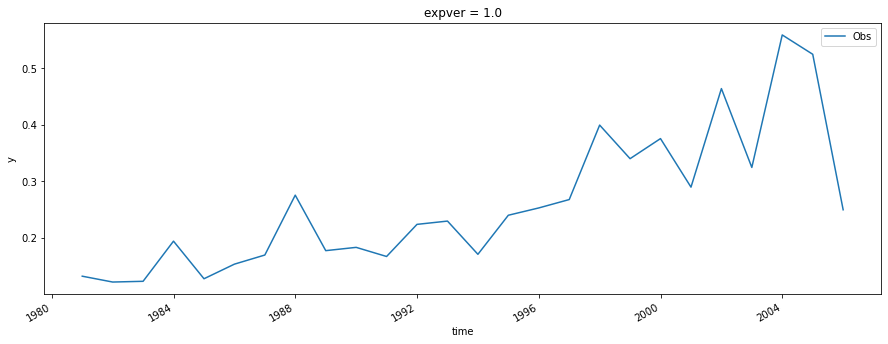

In [26]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
#y_pred_ds.resample(time='1M').mean().y_pred.dropna(dim='time').plot(label='GBPred')
#y_predLin_ds.resample(time='1M').mean().y_predLin.dropna(dim='time').plot(label='LRPred')
plt.legend()
#np.corrcoef(y_ds.y.values, y_pred_ds.y_pred.values)
print(stats.pearsonr(y_ds.y.values, y_pred_ds.y_pred.values))
print(stats.pearsonr(y_ds.y.values, y_predLin_ds.y_predLin.values))
#y_ds.y.values.corr(y_pred_ds.y_pred.values)

In [27]:
from joblib import dump, load

In [28]:
dump(reg, 'regGB_ObsLMDZ.joblib') 
dump(regLin,'regLR_ObsLMDZ.joblib')
dump(y_pred_ds,'y_pred_ds_ObsLMDZ.joblib')
dump(y_ds,'y_ds_ObsLMDZ.joblib')
dump(y_predLin_ds,'y_predLin_ds_ObsLMDZ.joblib')

['y_predLin_ds_ObsLMDZ.joblib']

In [29]:
y_ds.y.where(y_ds.y > 0.44, drop=True)
Widespread_y=y_ds.y.where(y_ds.y > 0.44, drop=True)
totalCnt=Widespread_y.time.sizes
totalCnt

Frozen({'time': 300})

In [33]:
Widespread_y.resample(time='1Y').count()

<xarray.DataArray 'y' (time: 23)>
array([ 7,  1,  1,  2, 11,  5,  5,  7,  3,  3,  3,  9,  9, 12, 29, 18, 21,
       16, 35, 15, 43, 37,  8])
Coordinates:
  * time     (time) datetime64[ns] 1983-12-31 1984-12-31 ... 2005-12-31
    expver   float64 1.0

In [34]:
Widespread_y_pred=y_pred_ds.y_pred.where(y_pred_ds.y_pred > 0.44, drop=True)
# Total number of widespread fog days
print(Widespread_y_pred.count())
# mean annual frequency
print(y_pred_ds.y_pred.where(y_pred_ds.y_pred > 0.44).resample(time='1Y').count().mean())
# interannual std 
print(y_pred_ds.y_pred.where(y_pred_ds.y_pred > 0.44).resample(time='1Y').count().std())
#Widespread_y_pred.resample(time='1Y').count()

<xarray.DataArray 'y_pred' ()>
array(208)
<xarray.DataArray 'y_pred' ()>
array(8.)
<xarray.DataArray 'y_pred' ()>
array(8.79685258)


In [35]:
Widespread_y=y_ds.y.where(y_ds.y > 0.44, drop=True)
# Total number of widespread fog days
print(Widespread_y.count())
# mean annual frequency
print(y_ds.y.where(y_ds.y > 0.44).resample(time='1Y').count().mean())
# interannual std 
print(y_ds.y.where(y_ds.y > 0.44).resample(time='1Y').count().std())
#Widespread_y_pred.resample(time='1Y').count()


<xarray.DataArray 'y' ()>
array(300)
Coordinates:
    expver   float64 1.0
<xarray.DataArray 'y' ()>
array(11.53846154)
Coordinates:
    expver   float64 1.0
<xarray.DataArray 'y' ()>
array(11.99432805)
Coordinates:
    expver   float64 1.0


In [36]:
Widespread_y_predLin=y_predLin_ds.y_predLin.where(y_predLin_ds.y_predLin > 0.44, drop=True)
# Total number of widespread fog days
print(Widespread_y_predLin.count())
# mean annual frequency
print(y_predLin_ds.y_predLin.where(y_predLin_ds.y_predLin > 0.44).resample(time='1Y').count().mean())
# interannual std 
print(y_predLin_ds.y_predLin.where(y_predLin_ds.y_predLin > 0.44).resample(time='1Y').count().std())
#Widespread_y_pred.resample(time='1Y').count()


<xarray.DataArray 'y_predLin' ()>
array(173)
<xarray.DataArray 'y_predLin' ()>
array(6.65384615)
<xarray.DataArray 'y_predLin' ()>
array(8.08580098)


In [37]:
Widespread_y_predLin=y_predLin_ds.y_predLin.where(y_predLin_ds.y_predLin > 0.44, drop=True)
Widespread_y_predLin.time


<xarray.DataArray 'time' (time: 173)>
array(['1980-12-24T00:00:00.000000000', '1980-12-25T00:00:00.000000000',
       '1980-12-26T00:00:00.000000000', '1980-12-28T00:00:00.000000000',
       '1982-01-10T00:00:00.000000000', '1982-01-27T00:00:00.000000000',
       '1982-12-29T00:00:00.000000000', '1983-01-04T00:00:00.000000000',
       '1983-01-05T00:00:00.000000000', '1987-01-17T00:00:00.000000000',
       '1987-01-18T00:00:00.000000000', '1987-01-19T00:00:00.000000000',
       '1987-12-12T00:00:00.000000000', '1987-12-15T00:00:00.000000000',
       '1987-12-16T00:00:00.000000000', '1989-12-24T00:00:00.000000000',
       '1989-12-25T00:00:00.000000000', '1989-12-26T00:00:00.000000000',
       '1989-12-29T00:00:00.000000000', '1989-12-30T00:00:00.000000000',
       '1989-12-31T00:00:00.000000000', '1990-01-01T00:00:00.000000000',
       '1990-01-02T00:00:00.000000000', '1990-01-03T00:00:00.000000000',
       '1990-01-04T00:00:00.000000000', '1990-01-12T00:00:00.000000000',
       '1991-12-17T00:00:00.000000000', '1991-12-18T00:00:00.000000000',
       '1991-12-22T00:00:00.000000000', '1991-12-23T00:00:00.000000000',
       '1991-12-25T00:00:00.000000000', '1991-12-26T00:00:00.000000000',
       '1993-01-09T00:00:00.000000000', '1994-01-13T00:00:00.000000000',
       '1994-01-14T00:00:00.000000000', '1994-01-15T00:00:00.000000000',
       '1995-01-09T00:00:00.000000000', '1995-12-30T00:00:00.000000000',
       '1995-12-31T00:00:00.000000000', '1996-01-03T00:00:00.000000000',
       '1997-12-01T00:00:00.000000000', '1997-12-07T00:00:00.000000000',
       '1997-12-10T00:00:00.000000000', '1997-12-11T00:00:00.000000000',
       '1997-12-12T00:00:00.000000000', '1997-12-13T00:00:00.000000000',
       '1997-12-14T00:00:00.000000000', '1997-12-15T00:00:00.000000000',
       '1997-12-17T00:00:00.000000000', '1997-12-18T00:00:00.000000000',
       '1997-12-19T00:00:00.000000000', '1997-12-20T00:00:00.000000000',
       '1997-12-21T00:00:00.000000000', '1997-12-22T00:00:00.000000000',
       '1997-12-23T00:00:00.000000000', '1997-12-24T00:00:00.000000000',
       '1997-12-25T00:00:00.000000000', '1997-12-26T00:00:00.000000000',
       '1997-12-27T00:00:00.000000000', '1997-12-28T00:00:00.000000000',
       '1997-12-29T00:00:00.000000000', '1997-12-30T00:00:00.000000000',
       '1997-12-31T00:00:00.000000000', '1998-01-01T00:00:00.000000000',
       '1998-01-02T00:00:00.000000000', '1998-01-03T00:00:00.000000000',
       '1998-01-04T00:00:00.000000000', '1998-01-05T00:00:00.000000000',
       '1998-01-06T00:00:00.000000000', '1998-01-07T00:00:00.000000000',
       '1998-01-08T00:00:00.000000000', '1998-01-09T00:00:00.000000000',
       '1998-12-16T00:00:00.000000000', '1998-12-17T00:00:00.000000000',
       '1998-12-18T00:00:00.000000000', '1998-12-19T00:00:00.000000000',
       '1998-12-20T00:00:00.000000000', '1998-12-22T00:00:00.000000000',
       '1998-12-24T00:00:00.000000000', '1998-12-25T00:00:00.000000000',
       '1998-12-27T00:00:00.000000000', '1998-12-28T00:00:00.000000000',
       '1998-12-29T00:00:00.000000000', '1998-12-30T00:00:00.000000000',
       '1998-12-31T00:00:00.000000000', '1999-01-02T00:00:00.000000000',
       '1999-01-10T00:00:00.000000000', '1999-01-11T00:00:00.000000000',
       '1999-01-12T00:00:00.000000000', '1999-01-13T00:00:00.000000000',
       '1999-01-14T00:00:00.000000000', '1999-01-15T00:00:00.000000000',
       '1999-01-16T00:00:00.000000000', '1999-01-17T00:00:00.000000000',
       '1999-01-18T00:00:00.000000000', '1999-01-19T00:00:00.000000000',
       '1999-01-20T00:00:00.000000000', '1999-01-21T00:00:00.000000000',
       '1999-12-28T00:00:00.000000000', '1999-12-29T00:00:00.000000000',
       '2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
       '2000-01-03T00:00:00.000000000', '2000-01-04T00:00:00.000000000',
       '2000-01-05T00:00:00.000000000', '2000-01-07T00:00:00.000000000',
       '2000-01-08T00:00:00.000000000', '2000-01-10T00:00:00.000000000',
       '2001-01-01T0

In [38]:
Widespread_y
#Widespread_y.time

<xarray.DataArray 'y' (time: 300)>
array([0.48, 0.52, 0.6 , 0.64, 0.6 , 0.6 , 0.48, 0.48, 0.48, 0.52, 0.48,
       0.48, 0.48, 0.6 , 0.48, 0.56, 0.48, 0.52, 0.48, 0.52, 0.48, 0.52,
       0.52, 0.56, 0.56, 0.64, 0.48, 0.48, 0.48, 0.6 , 0.52, 0.6 , 0.56,
       0.48, 0.6 , 0.6 , 0.56, 0.52, 0.48, 0.52, 0.48, 0.52, 0.48, 0.48,
       0.48, 0.52, 0.48, 0.52, 0.48, 0.48, 0.52, 0.56, 0.48, 0.6 , 0.6 ,
       0.6 , 0.48, 0.56, 0.48, 0.52, 0.56, 0.48, 0.56, 0.48, 0.48, 0.6 ,
       0.6 , 0.56, 0.6 , 0.48, 0.56, 0.56, 0.52, 0.48, 0.56, 0.52, 0.48,
       0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.52, 0.52, 0.48, 0.48,
       0.48, 0.6 , 0.72, 0.48, 0.68, 0.48, 0.56, 0.56, 0.52, 0.64, 0.68,
       0.52, 0.72, 0.64, 0.48, 0.72, 0.48, 0.48, 0.48, 0.48, 0.56, 0.48,
       0.48, 0.56, 0.56, 0.6 , 0.52, 0.48, 0.48, 0.48, 0.6 , 0.64, 0.56,
       0.6 , 0.64, 0.64, 0.52, 0.6 , 0.6 , 0.68, 0.52, 0.6 , 0.68, 0.56,
       0.52, 0.72, 0.6 , 0.64, 0.56, 0.52, 0.52, 0.48, 0.6 , 0.6 , 0.56,
       0.52, 0.52, 0.6 , 0.76, 0.84, 0.8 , 0.64, 0.8 , 0.64, 0.72, 0.76,
       0.76, 0.52, 0.52, 0.48, 0.48, 0.6 , 0.48, 0.48, 0.56, 0.52, 0.64,
       0.56, 0.56, 0.72, 0.88, 0.76, 0.52, 0.72, 0.72, 0.64, 0.52, 0.52,
       0.56, 0.56, 0.76, 0.68, 0.52, 0.56, 0.72, 0.72, 0.72, 0.68, 0.72,
       0.56, 0.52, 0.48, 0.52, 0.52, 0.56, 0.6 , 0.68, 0.68, 0.64, 0.68,
       0.92, 0.84, 0.64, 0.56, 0.52, 0.52, 0.48, 0.56, 0.52, 0.68, 0.64,
       0.52, 0.48, 0.64, 0.48, 0.84, 0.84, 0.6 , 0.52, 0.48, 0.64, 0.72,
       0.6 , 0.88, 0.84, 0.8 , 0.92, 0.72, 0.72, 0.76, 0.76, 0.8 , 0.88,
       0.84, 0.8 , 0.76, 0.72, 0.84, 0.76, 0.68, 0.48, 0.56, 0.48, 0.6 ,
       0.64, 0.76, 0.8 , 0.8 , 0.56, 0.64, 0.76, 0.72, 0.56, 0.48, 0.76,
       0.84, 0.68, 0.76, 0.76, 0.68, 0.68, 0.76, 0.84, 0.64, 0.6 , 0.64,
       0.8 , 0.72, 0.88, 0.8 , 0.72, 0.84, 0.92, 0.6 , 0.84, 0.88, 0.68,
       0.68, 0.52, 0.52, 0.48, 0.48, 0.64, 0.76, 0.68, 0.68, 0.76, 0.76,
       0.68, 0.8 , 0.76, 0.56, 0.56, 0.64, 0.48, 0.48, 0.48, 0.56, 0.52,
       0.56, 0.6 , 0.52])
Coordinates:
    expver   float64 1.0
  * time     (time) datetime64[ns] 1983-01-04T10:30:00 ... 2005-12-31T10:30:00

In [39]:
# Read z500 data
z500Data = xr.open_dataset('../../../Data/eraDown/ERA5to19/AnomERA5PerDay_.75_DecJan_1979_2019_z500_download.nc')
#z500Data


In [40]:
# to m 
z500Data.z.values=z500Data.z.values/9.81

In [41]:
time1=Widespread_y.time
time1

<xarray.DataArray 'time' (time: 300)>
array(['1983-01-04T10:30:00.000000000', '1983-01-05T10:30:00.000000000',
       '1983-01-06T10:30:00.000000000', ..., '2005-12-29T10:30:00.000000000',
       '2005-12-30T10:30:00.000000000', '2005-12-31T10:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    expver   float64 1.0
  * time     (time) datetime64[ns] 1983-01-04T10:30:00 ... 2005-12-31T10:30:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [42]:
z500Data.time

<xarray.DataArray 'time' (time: 2542)>
array(['1979-01-01T09:00:00.000000000', '1979-01-02T09:00:00.000000000',
       '1979-01-03T09:00:00.000000000', ..., '2019-12-29T09:00:00.000000000',
       '2019-12-30T09:00:00.000000000', '2019-12-31T09:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [43]:
zwide=z500Data.sel(time=Widespread_y.time,method="nearest")


In [44]:
zwide.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 121, longitude: 480, time: 300)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-04T09:00:00 ... 2005-12-31T09:00:00
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... 2.25 1.5 0.75 0.0
    expver     float64 1.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    z          (time, latitude, longitude) float32 -190.8 -190.8 ... -12.82
Attributes:
    CDI:          Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Thu Jul 16 21:01:07 2020: cdo -ydaysub ERA5PerDay_.75_DecJa...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/...>

zwide.to_netcdf("widespreadFogZ500Obs.nc")

In [45]:
zwidePos=zwide.z.where(zwide.z.sel(latitude=slice(40,20),longitude=slice(60,85)).mean(dim=['latitude','longitude']) > 0.0, drop=True)
PosCnt=zwidePos.time.sizes

In [46]:
zwideNeg=zwide.z.where(zwide.z.sel(latitude=slice(40,20),longitude=slice(60,85)).mean(dim=['latitude','longitude']) < 0.0, drop=True)
NegCnt=zwideNeg.time.sizes

In [47]:
zwideAll=zwide.z.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time')
#zwideAll

In [48]:
zNeg=zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time')
#zNeg
zPos=zwidePos.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time')
#zPos

In [49]:

def map_plot(ax1):
    ax1.coastlines()
    ax1.set_xticks([20,40 , 60,80, 100,120, 140], crs=ccrs.PlateCarree())
    ax1.set_yticks([ 10, 20, 30, 40, 50, 60,70], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

In [50]:
# for contour labels
delta = 5.0
x = np.arange(-60, 60, delta)
y = np.arange(-60, 60, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'


class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


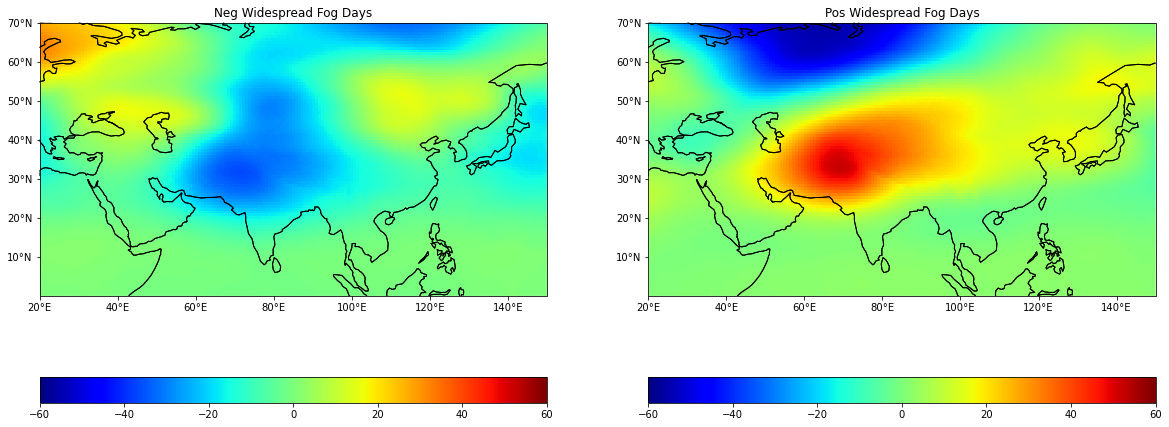

In [51]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.pcolor(zNeg.longitude.values,zNeg.latitude.values,zNeg,transform=ccrs.PlateCarree(),cmap='jet',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
ax1.set_title('Neg Widespread Fog Days')
fig.colorbar(m1,orientation='horizontal')

ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())

m2=ax2.pcolor(zPos.longitude.values,zPos.latitude.values,zPos,transform=ccrs.PlateCarree(),cmap='jet',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax2)
ax2.coastlines()
ax2.set_title('Pos Widespread Fog Days')

fig.colorbar(m2,orientation='horizontal')

plt.savefig('../WDF_pos_Negupto2005.jpeg',dpi=300)


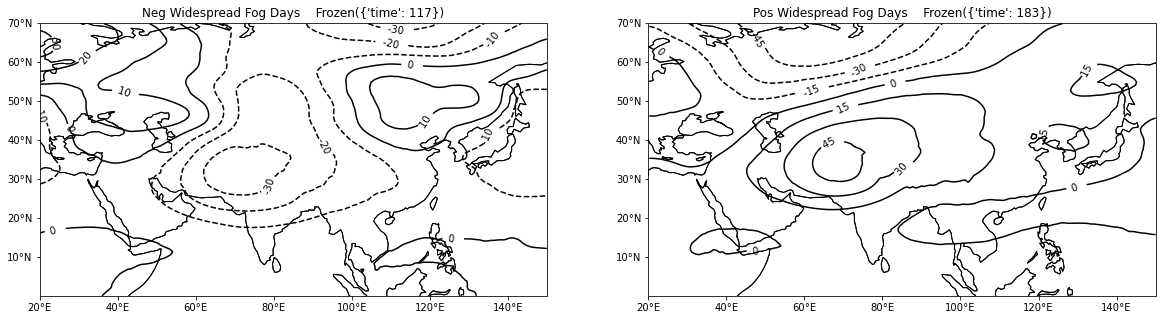

In [52]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contour(zNeg.longitude.values,zNeg.latitude.values,zNeg,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
# Recast levels to new class
m1.levels = [nf(val) for val in m1.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax1.clabel(m1, m1.levels, inline=True, fmt=fmt, fontsize=10)
ax1.set_title('Neg Widespread Fog Days'+"    "+str(NegCnt))
#fig.colorbar(m1,orientation='horizontal')


########## second Figure
ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
m2=ax2.contour(zPos.longitude.values,zPos.latitude.values,zPos,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
map_plot(ax2)
ax2.coastlines()

# Recast levels to new class
m2.levels = [nf(val) for val in m2.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax2.clabel(m2, m2.levels, inline=True, fmt=fmt, fontsize=10)

ax2.set_title('Pos Widespread Fog Days'+"    "+str(PosCnt))

#fig.colorbar(m2,orientation='horizontal')

plt.savefig('../WDF_pos_Negupto2005.jpeg',dpi=300)


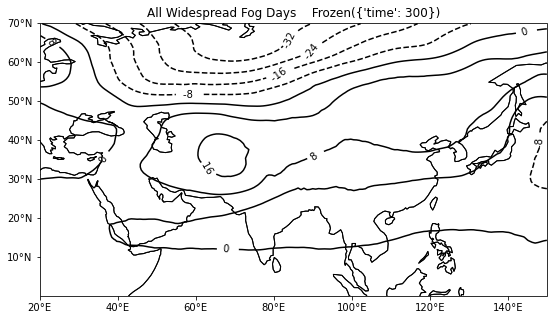

In [53]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contour(zwideAll.longitude.values,zwideAll.latitude.values,zwideAll,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
# Recast levels to new class
m1.levels = [nf(val) for val in m1.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax1.clabel(m1, m1.levels, inline=True, fmt=fmt, fontsize=10)
ax1.set_title('All Widespread Fog Days'+"    "+str(totalCnt) )
#fig.colorbar(m1,orientation='horizontal')
plt.savefig('../WDF_Allupto2005.jpeg',dpi=300)